# Reading in data

## Version two: Constructs two dataframes, with different approaches to label columns


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import seaborn as sns
import re 
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
import sklearn

import matplotlib.pyplot as plt

In [2]:
# Path to data
path = 'alldata/'

# String to specify ind date
end_date = '2020-04-26 23:59:00'


In [3]:
def make_dataframes(path):
    file_names = [pos_csv for pos_csv in os.listdir(path) if pos_csv.endswith('.csv')]
    dataframes = {}
    dfs = []
    for i, file in enumerate(file_names):
        df_name = ("df_" + file)[:-4]
        dfs.append(pd.read_csv(path + file))
        dataframes[df_name] = dfs[i]
    return dataframes, file_names

data_dict, files = make_dataframes(path)

In [4]:
# We created a dictionary of dataframes:
data_dict.keys()
# These are the dataframes:

dict_keys(['df_survey_raw', 'df_current_log', 'df_weather_log', 'df_weekpop_df', 'df_binned_weather_history', 'df_binned_current_log', 'df_image_label', 'df_curpop_df', 'df_image_label_isa', 'df_survey_clean'])

## Fix dataframes in advance of joining:

In [5]:
# We join them on the time_bin column:
data_dict['df_image_label_isa'] = data_dict['df_image_label_isa'].rename(columns={"timetaken": "time_bin"})
data_dict['df_curpop_df'] = data_dict['df_curpop_df'].rename(columns={'binned':'time_bin'})


In [6]:
def fix_time_format(df):
    """ 
    Turn format to same format for df with 'time_bin' datetime object column.
    """
    print("before:", df['time_bin'].dtype)
    df['time_bin']= pd.to_datetime(df['time_bin']) 
    print("after:", df['time_bin'].dtype)
#    df['time_bin'] = df['time_bin'].dt.strftime('%Y-%m-%d %H:%M')


In [7]:
# Read in pkl tweets into dataframe:
path_to_pkl = "alldata/geotweets_labeled_binned.pkl"

def read_pkl(path_to_pkl):
    tweets = pd.read_pickle(path_to_pkl)
    
    # Create tweets_safe (time bin column, safe score column)
    print(tweets.dtypes)
   # tweets['time_bin'] = tweets['time_bin'].astype(str)
    tweets_safe = tweets[pd.notnull(tweets['safe'])]
#     tweets_safe = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
#     #tweets_safe = tweets.groupby('time_bin').agg({'safe':['mean'], 'safe':['sum']})
#     print(len(tweets_safe))
#     tweets_safe = tweets_safe.drop(columns=['num_tweets'])
#     tweets_safe.columns
    tweets_safe = tweets_safe.reset_index()
    
    # tweets need to be changed to stardard labels: safe = 0, unsafe = 1
    tweets_safe["safe"] = tweets_safe["safe"].replace([0, 1], [1,0])
    
#    fix_time_format(tweets_safe)

    
    # create tweets_count (time bin column, number of tweets)
    tweets_count = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
    tweets_count = tweets_count.drop(columns=['avg_safe'])
    tweets_count = tweets_count.reset_index()
    
    
    return tweets_safe, tweets_count

tweets_safe, tweets_count = read_pkl(path_to_pkl)

date           datetime64[ns, US/Eastern]
text                               object
username                           object
day_of_week                        object
hour                                int64
safe                                int64
time_bin                   datetime64[ns]
dtype: object


# Make one big dataframe

In [8]:
# We want to create time_bins for all valid day/times (not only those with labels)
# These time bins will be populated with imputed data

# end_date is specified at the head of the notebook

all_tb = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2020-03-23 00:05:00', end_date,
                                      freq='15T'))
       .between_time('07:00','21:00')
       .index.strftime('%Y-%m-%dT%H:%M:%S')
       .tolist()
)


# This is silly: TODO: fix this part, is uneccessary!
all_tb = [all_tb[i][:10] + " " + all_tb[i][11:] for i in range(len(all_tb))]

# All time bins:
all_tb[0:5]

# # Create dataframe

df_tb = pd.DataFrame(all_tb)
df_tb = df_tb.rename(columns={0:'time_bin'})
fix_time_format(df_tb)
df_tb



before: object
after: datetime64[ns]


,time_bin
0,2020-03-23 07:05:00
1,2020-03-23 07:20:00
2,2020-03-23 07:35:00
3,2020-03-23 07:50:00
4,2020-03-23 08:05:00
...,...
1955,2020-04-26 19:50:00
1956,2020-04-26 20:05:00
1957,2020-04-26 20:20:00
1958,2020-04-26 20:35:00


In [9]:
considered_dfs = ['df_curpop_df',
                  'df_binned_current_log',
                  'df_image_label_isa',
                  'df_survey_clean',
                  'df_binned_weather_history']

def convert_and_examine_time(considered_dfs):
    for df in considered_dfs:
        print("df name:", df)
        fix_time_format(data_dict[df])
        print('begins:', data_dict[df]['time_bin'].min(), 
              "\nends:", data_dict[df]['time_bin'].max(), 
              "\nnon-na vals:", data_dict[df]['time_bin'].count(), "\n\n" )
    print("df name:", "tweets_safe")
    print('begins:', tweets_safe['time_bin'].min(), 
          "\nends:", tweets_safe['time_bin'].max(), 
          "\nnon-na vals:", tweets_safe['time_bin'].count())

convert_and_examine_time(considered_dfs)

df name: df_curpop_df
before: object
after: datetime64[ns]
begins: 2020-04-02 15:05:00 
ends: 2020-04-21 21:05:00 
non-na vals: 1750 


df name: df_binned_current_log
before: object
after: datetime64[ns]
begins: 2020-04-04 08:35:00 
ends: 2020-04-27 15:05:00 
non-na vals: 1775 


df name: df_image_label_isa
before: object
after: datetime64[ns]
begins: 2020-04-02 16:05:00 
ends: 2020-04-07 18:20:00 
non-na vals: 54 


df name: df_survey_clean
before: object
after: datetime64[ns]
begins: 2010-04-09 11:50:00 
ends: 2020-04-26 14:50:00 
non-na vals: 135 


df name: df_binned_weather_history
before: object
after: datetime64[ns]
begins: 2019-12-31 23:50:00 
ends: 2020-04-27 22:50:00 
non-na vals: 11325 


df name: tweets_safe
begins: 2020-03-23 14:05:00 
ends: 2020-04-26 19:05:00 
non-na vals: 364


In [10]:
def strip_non_sig(df, col):
    print("Length before removing NAs/twos:", len(df))
    df = df[df[col].notna()]

    df = df[df[col]!=2]
    print("Length after removing NAs/twos:", len(df))
    
    return df


In [11]:
# Join dataframes on time_bin column:

df_full_back = pd.merge(data_dict['df_curpop_df'], data_dict['df_binned_weather_history'], on='time_bin', how='outer')
df_full = df_full_back.copy()
print(len(df_full), df_full.columns)
df_full = pd.merge(df_tb, df_full, on = 'time_bin', how = 'left')
print(len(df_full))
# Standardize models

# labels from df_Survey_clean
var_mt = strip_non_sig(data_dict['df_survey_clean'],'main_track')
var_mt = pd.merge(var_mt[['time_bin','main_track']], df_full, on='time_bin', how='right')
var_mt = var_mt.rename(columns={'main_track':'label'})
var_mt['source'] = "mt"

# labels from df_image_label_isa (label column) (column is already named correctly)

var_label =  strip_non_sig(data_dict['df_image_label_isa'],'label')
var_label = pd.merge(var_label[['time_bin','label']], df_full, on='time_bin', how='right')
var_label['source'] = "h"

# labels from df_image_label_isa (Isa column)
var_isa = strip_non_sig(data_dict['df_image_label_isa'],'Isa')
var_isa = pd.merge(var_isa[['time_bin','Isa']], df_full, on='time_bin', how='right')
var_isa = var_isa.rename(columns={'Isa':'label'})
var_isa['source'] = "i"

# labels from tweets_safe (safe label)
var_tw = strip_non_sig(tweets_safe,'safe')
var_tw = pd.merge(var_tw[['time_bin','safe']], df_full, on='time_bin', how='right')
var_tw = var_tw.rename(columns={'safe':'label'})
var_tw['source'] = "tw"


# Join frames together
frames = [var_mt, var_label, var_isa, var_tw]
df_full = pd.concat(frames, ignore_index=True)
print(len(df_full))

# Create day/hour variables (since we suspect these may be relevant to how safe/unsafe PP is at in a given time_bin)
df_full['day_name'] = df_full['time_bin'].dt.day_name()
df_full['hour'] = df_full['time_bin'].dt.hour
df_full = df_full.drop(columns = ['time'])

print(len(df_full))

11898 Index(['Unnamed: 0', 'current_popularity', 'datetime', 'time_bin', 'time',
       'temp', 'humidity', 'rain_1h', 'wind_speed', 'wind_deg', 'press'],
      dtype='object')
2492
Length before removing NAs/twos: 135
Length after removing NAs/twos: 96
Length before removing NAs/twos: 54
Length after removing NAs/twos: 48
Length before removing NAs/twos: 54
Length after removing NAs/twos: 41
Length before removing NAs/twos: 364
Length after removing NAs/twos: 43
9994
9994


In [12]:
df_full.head(1)

,time_bin,label,Unnamed: 0,current_popularity,datetime,temp,humidity,rain_1h,wind_speed,wind_deg,press,source,day_name,hour
0,2020-04-08 18:20:00,1.0,579.0,43.0,2020-04-08 18:24:00,62.037388,61.670485,3.836297e-08,20.810762,346.028109,1001.249624,mt,Wednesday,18


In [13]:
def copy_and_concat_2(df, src):
    """
    source_val - source column label
    n - number of times to duplicate
    n_adj - how many times to duplicate label in adjacent time_bins 
    
    Returns a copy of df where rows with df.source == src are copied n/n_adj times.
    """
    # Copy of df rows from source = src
    df_src = df[df.source == src]
    
    # Create copy of rows, assign to previous time bin (-15 mins)
    df_before = df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] - timedelta(seconds=900)
    df_before['source'] = "copy"
    
    # Create copy of rows, assign to next time bin (+15 mins)
    df_after= df_src[df_src.source == src]
    df_after['time_bin'] = df_after['time_bin'] + timedelta(seconds=900)
    df_after['source'] = "copy"
    
    # Create copy of rows, assign to next time bin (+30 mins)
    df_after2= df_src[df_src.source == src]
    df_after2['time_bin'] = df_after2['time_bin'] + timedelta(seconds=1800)
    df_after2['source'] = "copy"
    

    df_return = pd.concat([df_before, df_after, df_after2], ignore_index=True)
    
    return df_return

In [14]:
df_temp = df_full.copy()


print("Before copying:", df_temp.shape)

df_mt = copy_and_concat_2(df_temp, src = 'mt')
df_new = pd.concat([df_temp, df_mt], ignore_index=True)
print("We add copies of source == mt,", df_mt.shape, ".\nAfter adding:", df_new.shape )

df_i = copy_and_concat_2(df_temp, src = 'i')
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == i,", df_i.shape, ".\nAfter adding:", df_new.shape )

df_h = copy_and_concat_2(df_temp, src = 'h')
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == h,", df_h.shape, ".\nAfter adding:", df_new.shape )

df_tw = copy_and_concat_2(df_temp, src = 'tw')
df_new = pd.concat([df_new, df_tw], ignore_index=True)
print("We add copies of source == tw,", df_h.shape, ".\nAfter adding:", df_new.shape )

# We check how many time bins with no datapoints we have left:
df_for_counting = df_new.copy()
print(df_for_counting.shape)
df_for_counting.head(1)


Before copying: (9994, 14)
We add copies of source == mt, (7551, 14) .
After adding: (17545, 14)
We add copies of source == i, (7476, 14) .
After adding: (25021, 14)
We add copies of source == h, (7476, 14) .
After adding: (32497, 14)
We add copies of source == tw, (7476, 14) .
After adding: (39976, 14)
(39976, 14)


,time_bin,label,Unnamed: 0,current_popularity,datetime,temp,humidity,rain_1h,wind_speed,wind_deg,press,source,day_name,hour
0,2020-04-08 18:20:00,1.0,579.0,43.0,2020-04-08 18:24:00,62.037388,61.670485,3.836297e-08,20.810762,346.028109,1001.249624,mt,Wednesday,18


In [15]:
len(all_tb)

1960

In [16]:
## Split into dataframes with real observations vs imputed

df_full_obs = df_for_counting[df_for_counting.source != 'copy']
df_full_imputed = df_for_counting[df_for_counting.source == 'copy']
# df_full_imputed = df_full_imputed[df_full_imputed['time_bin'] != df_full_imputed.time_bin.max()]
# df_full_imputed = df_full_imputed[df_full_imputed['time_bin'] != df_full_imputed.time_bin.min()]

In [17]:

agg = {
    'label': 'size',       
    'label': lambda x: x.mean(skipna=True),
}

df_g_obs = df_full_obs.groupby(['time_bin']).agg(agg).reset_index()


#df_g_obs = df_full_obs.groupby('time_bin').agg(n=('label', 'size'), avg =('label', 'mean'))
df_g_imp = df_full_imputed.groupby(['time_bin']).agg(agg).reset_index()
print(df_g_obs.shape, df_g_imp.shape)

print("Observed:")
print(df_g_obs['label'].value_counts(dropna=False))
print("Imputed:")
print(df_g_imp['label'].value_counts(dropna=False))
df_g_imp['source'] = "imp"
df_g_obs['source'] = "obs"

(1960, 2) (2065, 2)
Observed:
NaN         1803
0.000000      76
1.000000      62
0.500000      16
0.333333       2
0.666667       1
Name: label, dtype: int64
Imputed:
NaN         1668
1.000000     194
0.000000     171
0.500000      14
0.666667       8
0.333333       5
0.750000       2
0.200000       1
0.777778       1
0.800000       1
Name: label, dtype: int64


In [18]:
print(df_g_obs.time_bin.min(), df_g_imp.time_bin.min() )
print(df_g_obs.time_bin.max(), df_g_imp.time_bin.max() )

2020-03-23 07:05:00 2020-03-23 06:50:00
2020-04-26 20:50:00 2020-04-26 21:20:00


In [19]:
df_all = df_tb.copy()
df_all = pd.merge(df_all, df_g_obs, on='time_bin', how='left')

df_all = pd.merge(df_all, df_g_imp, on='time_bin', how='outer')
df_all.head()
print(len(df_all))

df_all['source'] = np.where(df_all['label_x'].notnull(), 'obs', 'mis/imp')

df_all['label'] = df_all['label_x'].fillna(df_all['label_y'])

print(df_all['label'].value_counts(dropna=False))

print(df_all['label_x'].value_counts(dropna=False))

print(df_all['label_y'].value_counts(dropna=False))
df_all

2065
NaN         1550
1.000000     235
0.000000     233
0.500000      26
0.666667       9
0.333333       7
0.750000       2
0.200000       1
0.777778       1
0.800000       1
Name: label, dtype: int64
NaN         1908
0.000000      76
1.000000      62
0.500000      16
0.333333       2
0.666667       1
Name: label_x, dtype: int64
NaN         1668
1.000000     194
0.000000     171
0.500000      14
0.666667       8
0.333333       5
0.750000       2
0.200000       1
0.777778       1
0.800000       1
Name: label_y, dtype: int64


,time_bin,label_x,source_x,label_y,source_y,source,label
0,2020-03-23 07:05:00,NaN,obs,NaN,imp,mis/imp,NaN
1,2020-03-23 07:20:00,NaN,obs,NaN,imp,mis/imp,NaN
2,2020-03-23 07:35:00,NaN,obs,NaN,imp,mis/imp,NaN
3,2020-03-23 07:50:00,NaN,obs,NaN,imp,mis/imp,NaN
4,2020-03-23 08:05:00,NaN,obs,NaN,imp,mis/imp,NaN
...,...,...,...,...,...,...,...
2060,2020-04-25 21:05:00,NaN,NaN,NaN,imp,mis/imp,NaN
2061,2020-04-25 21:20:00,NaN,NaN,NaN,imp,mis/imp,NaN
2062,2020-04-26 06:50:00,NaN,NaN,NaN,imp,mis/imp,NaN
2063,2020-04-26 21:05:00,NaN,NaN,NaN,imp,mis/imp,NaN


In [20]:
df_all = df_all[['time_bin', 'label', 'source']]
df_all

,time_bin,label,source
0,2020-03-23 07:05:00,NaN,mis/imp
1,2020-03-23 07:20:00,NaN,mis/imp
2,2020-03-23 07:35:00,NaN,mis/imp
3,2020-03-23 07:50:00,NaN,mis/imp
4,2020-03-23 08:05:00,NaN,mis/imp
...,...,...,...
2060,2020-04-25 21:05:00,NaN,mis/imp
2061,2020-04-25 21:20:00,NaN,mis/imp
2062,2020-04-26 06:50:00,NaN,mis/imp
2063,2020-04-26 21:05:00,NaN,mis/imp


In [21]:
df_all.to_csv('df_imputed.csv', index = False, header=True)


In [22]:
print(df_all['label'].value_counts(dropna=False))

df_full_back['day_name'] = df_full_back['time_bin'].dt.day_name()
df_full_back['hour'] = df_full_back['time_bin'].dt.hour
df_full_back = df_full_back.drop(columns = ['time'])
df_full_back

NaN         1550
1.000000     235
0.000000     233
0.500000      26
0.666667       9
0.333333       7
0.750000       2
0.200000       1
0.777778       1
0.800000       1
Name: label, dtype: int64


,Unnamed: 0,current_popularity,datetime,time_bin,temp,humidity,rain_1h,wind_speed,wind_deg,press,day_name,hour
0,0.0,38.0,2020-04-02 15:17:00,2020-04-02 15:05:00,48.665660,50.000966,-1.021089e-13,45.213251,330.366284,1005.403648,Thursday,15
1,1.0,39.0,2020-04-02 15:27:00,2020-04-02 15:20:00,49.385369,48.752956,-2.575603e-13,42.420175,330.878998,1005.267367,Thursday,15
2,2.0,38.0,2020-04-02 15:37:00,2020-04-02 15:35:00,50.187393,47.378468,-2.842315e-13,39.292012,330.952213,1005.147403,Thursday,15
3,3.0,42.0,2020-04-02 15:47:00,2020-04-02 15:35:00,50.187393,47.378468,-2.842315e-13,39.292012,330.952213,1005.147403,Thursday,15
4,4.0,42.0,2020-04-02 15:48:00,2020-04-02 15:35:00,50.187393,47.378468,-2.842315e-13,39.292012,330.952213,1005.147403,Thursday,15
...,...,...,...,...,...,...,...,...,...,...,...,...
11893,NaN,NaN,NaN,2020-04-27 21:50:00,50.180000,54.000000,0.000000e+00,24.100000,351.000000,1014.800000,Monday,21
11894,NaN,NaN,NaN,2020-04-27 22:05:00,49.899035,54.364885,-5.909751e-04,23.889281,351.429245,1014.972255,Monday,22
11895,NaN,NaN,NaN,2020-04-27 22:20:00,49.625380,54.653180,-7.879668e-04,23.819042,351.905660,1015.129673,Monday,22
11896,NaN,NaN,NaN,2020-04-27 22:35:00,49.359035,54.864885,-5.909751e-04,23.889281,352.429245,1015.272255,Monday,22


In [23]:
df_full_back = pd.merge(df_all, df_full_back, on='time_bin', how='left')
df_full_back.shape

(2606, 14)

In [24]:
df_full_back

,time_bin,label,source,Unnamed: 0,current_popularity,datetime,temp,humidity,rain_1h,wind_speed,wind_deg,press,day_name,hour
0,2020-03-23 07:05:00,NaN,mis/imp,NaN,NaN,NaN,37.218220,67.589829,-3.887854e-07,24.037063,96.668017,1036.833625,Monday,7
1,2020-03-23 07:20:00,NaN,mis/imp,NaN,NaN,NaN,37.489544,67.559304,-9.806752e-07,23.988243,93.133023,1036.474436,Monday,7
2,2020-03-23 07:35:00,NaN,mis/imp,NaN,NaN,NaN,37.761095,67.249127,-1.082227e-06,23.995301,90.531517,1036.128030,Monday,7
3,2020-03-23 07:50:00,NaN,mis/imp,NaN,NaN,NaN,37.940000,67.000000,0.000000e+00,24.100000,90.000000,1035.900000,Monday,7
4,2020-03-23 08:05:00,NaN,mis/imp,NaN,NaN,NaN,38.026258,66.811923,2.266007e-06,24.302341,91.538473,1035.790348,Monday,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2020-04-25 21:05:00,NaN,mis/imp,NaN,NaN,NaN,53.602854,60.118153,6.030672e-12,23.325758,169.392765,1018.406510,Saturday,21
2602,2020-04-25 21:20:00,NaN,mis/imp,NaN,NaN,NaN,53.764290,60.355713,1.521181e-11,21.674867,165.480325,1018.466801,Saturday,21
2603,2020-04-26 06:50:00,NaN,mis/imp,NaN,NaN,NaN,48.200000,87.000000,0.000000e+00,13.000000,60.000000,1017.900000,Sunday,6
2604,2020-04-26 21:05:00,NaN,mis/imp,NaN,NaN,NaN,46.412965,99.998622,-2.495139e-04,32.801215,40.930163,1006.172046,Sunday,21


In [25]:
df_full_back = df_full_back[['time_bin', 'label', 'source', 
                            'current_popularity', 'temp', 'humidity', 'wind_deg', 'press', 'rain_1h','wind_speed' ]]

In [26]:
df_full_back.to_csv('df_imputed_fulldf.csv', index = False, header=True)


In [33]:
df_all

,time_bin,label,source
0,2020-03-23 07:05:00,NaN,mis/imp
1,2020-03-23 07:20:00,NaN,mis/imp
2,2020-03-23 07:35:00,NaN,mis/imp
3,2020-03-23 07:50:00,NaN,mis/imp
4,2020-03-23 08:05:00,NaN,mis/imp
...,...,...,...
2060,2020-04-25 21:05:00,NaN,mis/imp
2061,2020-04-25 21:20:00,NaN,mis/imp
2062,2020-04-26 06:50:00,NaN,mis/imp
2063,2020-04-26 21:05:00,NaN,mis/imp


In [32]:
len(df_all) == len(df_all['time_bin'].value_counts())

True

In [31]:
len(df_all['time_bin'].value_counts())

2065

# EDA of original data

Drop rows that we don't have zeros or ones for:

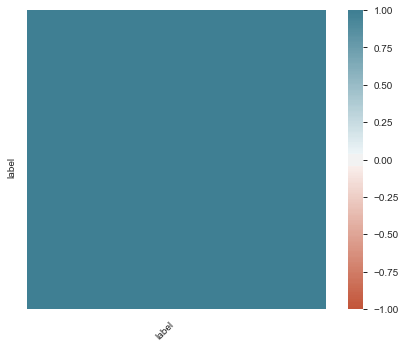

In [29]:
corr = df_all.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We can probably do something a bit more meaningful by exploding day_name:

In [30]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['day_name']]).toarray())

# merge with main df bridge_df on key values
df_m = df.join(enc_df)
df_m.head(1)


NameError: name 'df' is not defined

In [ ]:
corr = df_m.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Look at some counts w/crosstab:

In [ ]:
# Table of survival vs passenger class
t1 = pd.crosstab(index=df_m["label"], columns=df_m["day_name"])
t1.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [ ]:
t2 = pd.crosstab(index=df_m["hour"], columns=df_m["day_name"])

t2.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [ ]:
t3 = pd.crosstab(index=df_m["label"], columns=df_m["hour"])
t3

In [ ]:
t4 = pd.crosstab(index=df_m["hour"], columns=df_m["label"])

t4.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

# MVP Model

In [ ]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
df_m = df_m[['label', 'current_popularity', 'temp', 'press', 'wind_speed', 'hour', 0,1,2,3,4,5,6]]
df_m.head(1)

In [ ]:
print(df_m.shape)
df_m = df_m.dropna()
print(df_m.shape)

In [ ]:
x = df_m.drop('label',axis = 1)
y = df_m['label']

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=4)

# Create model
clf = LogisticRegression(random_state=0).fit(x_train, y_train)


y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy

print("accuracy:", accuracy_percentage)
print("\nClassificationReport")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix")

# cm = confusion_matrix(y.tolist(), y_pred.tolist())

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(cm)
# ax.grid(False)
# ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
# ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
# ax.set_ylim(1.5, -0.5)
# for i in range(2):
#     for j in range(2):
#         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
# plt.show()

# print(confusion_matrix)


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ROC could be better, but not too bad for a first pass.

# Imputing data

Trying out a few different things to see how these strategies change data.

In [ ]:
df_full.shape

In [ ]:
df_zo.shape

Using naive strategies to impute data:

In [ ]:
def copy_and_concat_(df, src):
    """
    source_val - source column label
    n - number of times to duplicate
    n_adj - how many times to duplicate label in adjacent time_bins 
    
    Returns a copy of df where rows with df.source == src are copied n/n_adj times.
    """
    # Copy of df rows from source = src
    df_src = df[df.source == src]
    
    # Create copy of rows, assign to previous time bin (-15 mins)
    df_before = df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] - timedelta(seconds=900)
    
    # Create copy of rows, assign to next time bin (+15 mins)
    df_after= df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] + timedelta(seconds=900)
    
    # Create copy of rows, assign to next time bin (+30 mins)
    df_after= df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] + timedelta(seconds=1800)
    

    df_return = df_src.copy()
    for i in range(n):
        df_return = pd.concat([df_return, df_src], ignore_index=True)
        
    for i in range(n_adj):
        df_return = pd.concat([df_return, df_after], ignore_index=True)
        df_return = pd.concat([df_return, df_before], ignore_index=True)
    
    return df_return

In [ ]:
print("Before copying:", df_tb.shape)

df_mt = copy_and_concat(df_tb, 'mt', 6, 3)
df_new = pd.concat([df_tb, df_mt], ignore_index=True)
print("We add copies of source == mt,", df_mt.shape, ".\nAfter adding:", df_new.shape )

df_i = copy_and_concat(df_tb, 'i', 4, 2)
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == i,", df_i.shape, ".\nAfter adding:", df_new.shape )

df_h = copy_and_concat(df_tb, 'h', 4, 2)
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == h,", df_h.shape, ".\nAfter adding:", df_new.shape )

df_tw = copy_and_concat(df_tb, 'tw', 2, 1)
df_new = pd.concat([df_new, df_tw], ignore_index=True)
print("We add copies of source == tw,", df_h.shape, ".\nAfter adding:", df_new.shape )

# We check how many time bins with no datapoints we have left:
df_for_counting = df_new.copy()
print(df_for_counting.shape)
df_for_counting.head(1)


In [ ]:
def checking_nonna(df):
    print("Before dropping we have", df.shape, "observations left.")
    print(df['label'].value_counts(dropna=False))
    df = df[df['label'].notna()]
    print(df['label'].value_counts(dropna=False))
    print(df['label'].dtypes)
    print(df.columns)
    df = df[['time_bin', 'label', 'current_popularity',
           'temp', 'humidity', 'press',
           'wind_speed', 'day_name', 'source', 'hour']]
    df = df[df['label']!=2]
    print(df['label'].value_counts(dropna=False))
    print(df.columns)
    print("After dropping we have", df.shape, "observations left.")

checking_nonna(df_for_counting)
df_for_counting['time_bin'].value_counts()

print("# of unlabeled time_bins is", len(all_tb)-df_for_counting['time_bin'].nunique(), "<- something is weird here, Check!")

In [ ]:
df_for_counting['time_bin'].nunique()

# Creating a new dataframe with all timebins

In [ ]:
all_tb[0:3]
len(all_tb)

In [ ]:
df_tb = pd.merge(df_full, df_tb, on='time_bin', how='outer')
len(df_tb)

In [ ]:
# Join dataframes on time_bin column:

df_full = pd.merge(data_dict['df_curpop_df'], data_dict['df_binned_weather_history'], on='time_bin', how='outer')

# Standardize models

# labels from df_Survey_clean
var_mt = pd.merge(data_dict['df_survey_clean'][['time_bin','main_track']], df_full, on='time_bin', how='left')
var_mt = var_mt.rename(columns={'main_track':'label'})
var_mt['source'] = "mt"

# labels from df_image_label_isa (label column) (column is already named correctly)
var_label = pd.merge(data_dict['df_image_label_isa'][['time_bin','label']], df_full, on='time_bin', how='left')
var_label['source'] = "h"

# labels from df_image_label_isa (Isa column)
var_isa = pd.merge(data_dict['df_image_label_isa'][['time_bin','Isa']], df_full, on='time_bin', how='left')
var_isa = var_isa.rename(columns={'Isa':'label'})
var_isa['source'] = "i"

# labels from tweets_safe (safe label)
var_tw = pd.merge(tweets_safe[['time_bin','safe']], df_full, on='time_bin', how='left')
var_tw = var_tw.rename(columns={'safe':'label'})
var_tw['source'] = "tw"

# Join frames together
frames = [var_mt, var_label, var_isa, var_tw]
df_full = pd.concat(frames, ignore_index=True)

# Create day/hour variables (since we suspect these may be relevant to how safe/unsafe PP is at in a given time_bin)
df_full['day_name'] = df_full['time_bin'].dt.day_name()
df_full['hour'] = df_full['time_bin'].dt.hour
df_full = df_full.drop(columns = ['time'])